In [163]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

from svgd import svgd, update, phi_j_batched, phi_j, kernel_param_update_rule
vkernel_param_update_rule = vmap(kernel_param_update_rule, 1)

## generate data

In [187]:
n = 100
d = 2
key = random.PRNGKey(0)
x0 = random.normal(key, shape=(n, d)) - 10

stepsize = 0.001
L = int(1 / stepsize)

In [188]:
from jax.scipy.stats import norm

@jit
def logp(x):
    """
    Parameters: 
    * x: np array of shape (d,)
    
    Returns: 
    * scalar log(p(x)), where p(x) is multidim gaussian
    """
    assert x.ndim == 1
    out = np.sum(norm.logpdf(x, loc=0, scale=1))
    return np.squeeze(out) # to be able to take a gradient, output must be scalar

In [189]:
xout, log = svgd(x0, logp, stepsize, L, kernel_param=None, kernel_param_update_rule=vkernel_param_update_rule)
if "errors" in log.keys():
    print(log["errors"])

In [190]:
np.var(xout, axis=0)

DeviceArray([1.1732652, 1.1401101], dtype=float32)

In [191]:
np.mean(xout, axis=0)

DeviceArray([-0.16193964, -0.15277971], dtype=float32)

In [192]:
len(log["particle_mean"])

1001

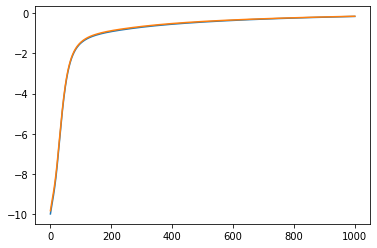

In [193]:
plt.plot(log["particle_mean"])

# testing
where does the NaN come from?

In [117]:
from utils import ard

In [133]:
x0.shape

(10, 2)

In [151]:
# x = x0[:, 0]
# x = np.reshape(x, newshape=(n, 1))
x = x0
print(x.shape)
kernel_param = kernel_param_update_rule(x)

(10, 2)


In [155]:
xj = x[0]
xi = x[1]

In [159]:
xj

DeviceArray([ -8.945484, -10.969289], dtype=float32)

In [161]:
norm.logpdf(xj, loc=0, scale=1)

DeviceArray([-40.929783, -61.081585], dtype=float32)

In [160]:
logp(xj)

DeviceArray(2500.056, dtype=float32)

In [156]:
grad(logp)(xj)

DeviceArray([-546.40436, -448.9706 ], dtype=float32)

In [157]:
kernel(xj, xi)

DeviceArray(0.7169002, dtype=float32)

In [158]:
grad(kernel)(xj, xi)

DeviceArray([-0.21870008,  0.12431493], dtype=float32)

In [66]:
kernel_params = []

In [130]:
# update kernel:
kernel_param = vkernel_param_update_rule(x)
kernel_params.append(kernel_param)
kernel = lambda x, y: ard(x, y, kernel_param)

# update x:
xnew = []
n = x.shape[0]
for i, xi in enumerate(x):
    repeated = np.tile(xi, (n, 1))
    xnew.append(stepsize * np.sum(phi_j_batched(x, repeated, logp, kernel), axis = 0))
xnew = np.array(xnew)
xnew += x
x = xnew

np.mean(x, axis=0)

DeviceArray([-9.618065, -9.941092], dtype=float32)